# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
!pip install jupyter_dash #dashboard
!pip install --upgrade plotly #dashbaord extension
!pip install lime #xai 2
!pip install shap #xai 1
!pip install kaleido #save images

In [3]:
import os
import datetime
import time
import timeit

import pandas as pd
import numpy as np

import io
import base64

# vis
import plotly
plotly.offline.init_notebook_mode()

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline


#dropdown
import ipywidgets as widgets
import IPython
from IPython.display import Image
from IPython.core.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual

# deep learning
import tensorflow as tf
from tensorflow import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# dashboard
import dash 
from jupyter_dash import JupyterDash 
import dash_core_components as dcc 
import dash_html_components as html 
import plotly.express as px
from dash.dependencies import Input, Output

# xai
import shap

%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

Output hidden; open in https://colab.research.google.com to view.

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [5]:
folder_deep_weeds = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds'
data_folder = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/data'
models_folder = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/models'
test_folder = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/data/test_oneClass2'
test_folder_lime = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/data/test_lime'

test_folder_lime_test = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/data/test_lime/test'

CLASSES = [
 'Chinee apple',
 'Lantana',
 'Negative',
 'Parkinsonia',
 'Parthenium',
 'Prickly acacia',
 'Rubber vine',
 'Siam weed',
 'Snake weed']

In [6]:
def loadModelAndResuls(directory):
  model = tf.keras.models.load_model(os.path.join(models_folder,directory, 'model.h5'))
  results_combined = pd.read_csv(os.path.join(models_folder,directory, 'predictions.csv'))
  return model, results_combined

In [7]:
selectable_models = [] # start with chain models ->

for dir in os.listdir(models_folder):
  datetim_string = str(dir).split("_")
  datetim_string = str(datetim_string[0]) +"__" + str(datetim_string[2])
  datetime_object = datetime.datetime.strptime(datetim_string,'%Y-%m-%d__%H-%M-%S')

  threshold =  datetime.datetime.strptime("2022-03-25__18-20-00",'%Y-%m-%d__%H-%M-%S') # fix all chain experiments
  if datetime_object > threshold:
    selectable_models.append(dir)

# Load the model

In [8]:
selectable_models

['2022-03-27__22-21-46_MobileNetV2_VShapeTraining',
 '2022-03-27__22-45-24_MobileNetV2_VShapeTraining_2',
 '2022-03-28__06-33-07_Chain_2_MobileNetV2_hillLR_full_dataset__medium_lr',
 '2022-03-28__05-32-05_Chain_2_MobileNetV2_hillLR_full_dataset__low_lr',
 '2022-03-28__04-48-45_Chain_2_MobileNetV2_hillLR_full_dataset__vvvery_low_lr',
 '2022-03-28__03-31-55_Chain_2_MobileNetV2_hillLR_full_dataset__vvvery_low_lr',
 '2022-03-28__02-15-37_Chain_2_MobileNetV2_hillLR_full_dataset__vvery_low_lr',
 '2022-03-28__00-59-17_Chain_2_MobileNetV2_hillLR_full_dataset__very_low_lr',
 '2022-03-28__00-42-17_Chain_3_MobileNetV2_hillLR_high_lr',
 '2022-03-28__00-35-12_Chain_3_MobileNetV2_hillLR_medium_lr',
 '2022-03-28__00-29-08_Chain_3_MobileNetV2_hillLR_low_lr',
 '2022-03-28__00-23-01_Chain_3_MobileNetV2_hillLR_vvvery_low_lr',
 '2022-03-28__00-11-21_Chain_3_MobileNetV2_hillLR_vvvery_low_lr',
 '2022-03-27__23-59-52_Chain_3_MobileNetV2_hillLR_vvery_low_lr',
 '2022-03-27__23-48-45_Chain_3_MobileNetV2_hillLR_

In [9]:
# select the model
selected_model_folder = '2022-03-28__00-59-17_Chain_2_MobileNetV2_hillLR_full_dataset__very_low_lr'

In [10]:
# load the model
model, results_combined = loadModelAndResuls(selected_model_folder)

# Lime

Use Lime
https://towardsdatascience.com/idea-behind-lime-and-shap-b603d35d34eb

Main paper: https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf / https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

# Own model

In [11]:
os.listdir(test_folder_lime_test)

['20170714-143003-2.jpg',
 '20180322-133802-1.jpg',
 '20171219-123823-2.jpg',
 '20171218-110718-2.jpg']

In [12]:
image1_path = os.path.join(test_folder_lime_test,'20180322-133802-1.jpg')
image2_path = os.path.join(test_folder_lime_test,'20171218-110718-2.jpg')
image3_path = os.path.join(test_folder_lime_test,'20171219-123823-2.jpg')

# XAI with Lime

In [13]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        # x = inc_net.preprocess_input(x)
        x = x/255 #right preprocessing
        out.append(x)
    return np.vstack(out)


In [14]:
images_lime = transform_img_fn([image2_path])


In [15]:
explainer = lime_image.LimeImageExplainer()


In [16]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images_lime[0].astype('double'), model, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 10.6 s, sys: 546 ms, total: 11.2 s
Wall time: 11.2 s


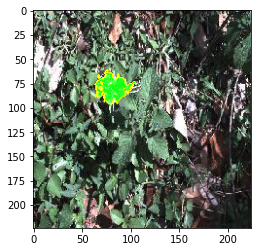

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp , mask))

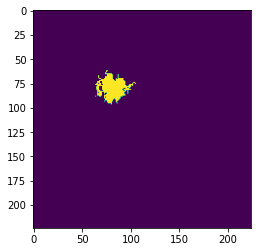

In [18]:
plt.imshow(mask)

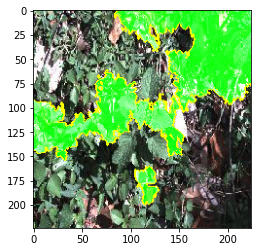

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

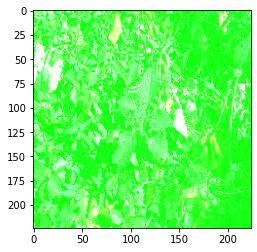

In [20]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

In [21]:
IMPORTANTCLASS = 0

Text(0.5, 1.0, 'Important Range 1 to 1')

Text(0.5, 1.0, 'Important Range 1 to 2')

Text(0.5, 1.0, 'Important Range 1 to 3')

Text(0.5, 1.0, 'Important Range 1 to 4')

Text(0.5, 1.0, 'Important Range 1 to 5')

Text(0.5, 1.0, 'Important Range 1 to 6')

Text(0.5, 1.0, 'Important Range 1 to 7')

Text(0.5, 1.0, 'Important Range 1 to 8')

Text(0.5, 1.0, 'Important Range 1 to 9')

Text(0.5, 1.0, 'Important Range 1 to 10')

Text(0.5, 1.0, 'Important Range 1 to 11')

Text(0.5, 1.0, 'Important Range 1 to 12')

Text(0.5, 1.0, 'Important Range 1 to 13')

Text(0.5, 1.0, 'Important Range 1 to 14')

Text(0.5, 1.0, 'Important Range 1 to 15')

Text(0.5, 1.0, 'Important Range 1 to 16')

Text(0.5, 1.0, 'Important Range 1 to 17')

Text(0.5, 1.0, 'Important Range 1 to 18')

Text(0.5, 1.0, 'Important Range 1 to 19')

Text(0.5, 1.0, 'Important Range 1 to 20')

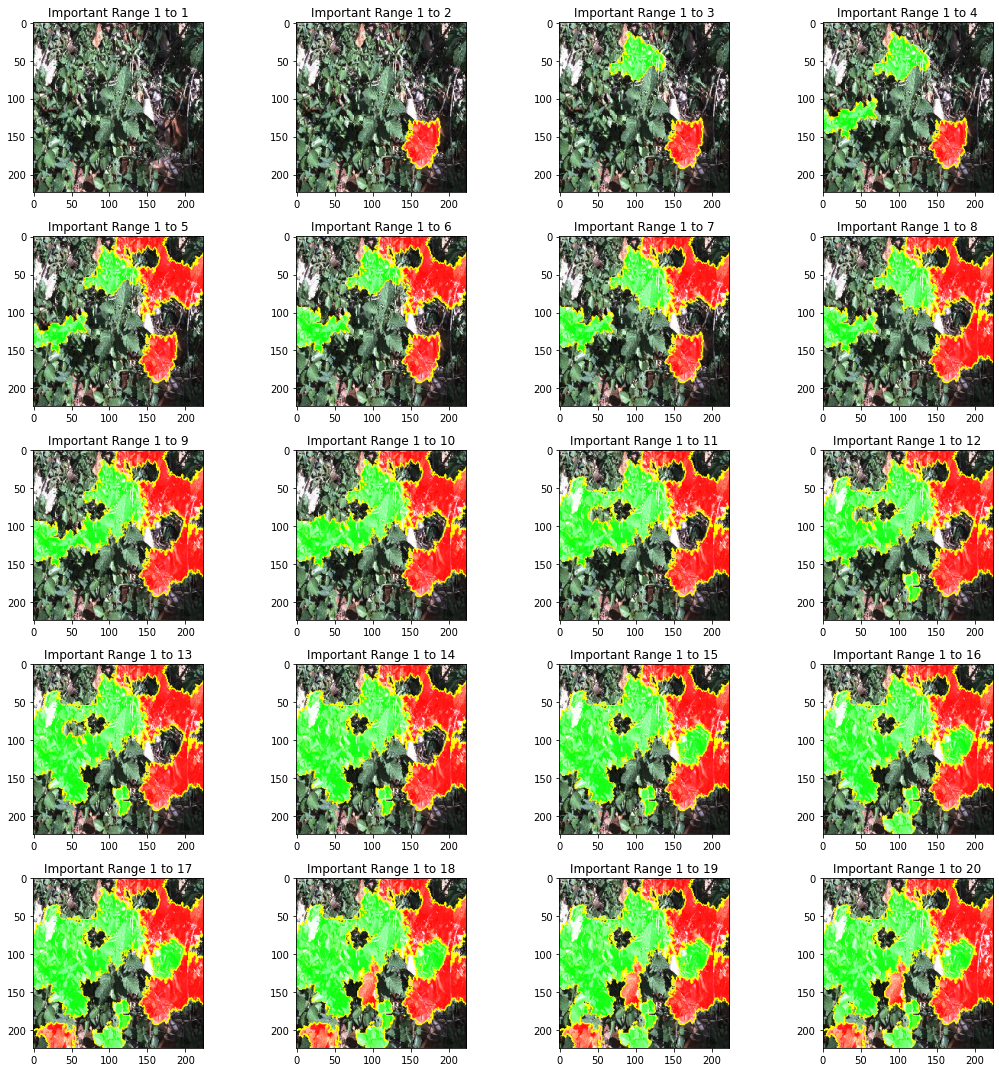

In [22]:
IMPORTANTCLASS = 0

amount_of_pic = 20

line = 0
i_line = 0
figure, axes = plt.subplots(nrows=(int(amount_of_pic/5))+1, ncols=4,figsize=(15, 15))
for i in range(0,amount_of_pic):  
    temp, mask = explanation.get_image_and_mask(IMPORTANTCLASS, positive_only=False, num_features=i, hide_rest=False)#hide_rest=False)
 
    if i % 4 == 0 and i != 0:
        line = line+1
        i_line = 0
    
    axes[line,i_line].imshow(mark_boundaries(temp, mask))
    axes[line,i_line].set_title('Important Range 1 to {}'.format(i+1))
    i_line = i_line+1

figure.tight_layout()

# XAI with Shap

https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html#SHAP-ResNet50-model-explanation-for-images

In [23]:
def load_Image_no_transform(path_img):
  img = load_img(path_img, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  img_batch = img_batch/255
  return img_batch


In [24]:

images =load_Image_no_transform(image2_path)  # transform_img_fn(image2_path), transform_img_fn(image3_path) 

In [25]:
model.predict(images)

array([[1.0891956e-01, 2.5567615e-01, 3.7348941e-01, 9.7658114e-05,
        2.1571971e-01, 3.4305489e-05, 2.6748414e-04, 1.1725435e-04,
        4.5678437e-02]], dtype=float32)

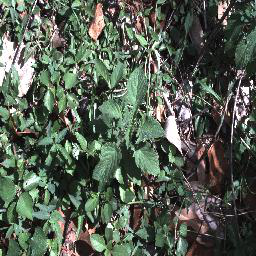

In [26]:
load_img(image2_path, target_size=(256, 256))

In [27]:
model.predict(images)

array([[1.0891956e-01, 2.5567615e-01, 3.7348941e-01, 9.7658114e-05,
        2.1571971e-01, 3.4305489e-05, 2.6748414e-04, 1.1725435e-04,
        4.5678437e-02]], dtype=float32)

In [28]:
def f_own(x):
  return model.predict(x)

In [29]:
f_own(images)

array([[1.0891956e-01, 2.5567615e-01, 3.7348941e-01, 9.7658114e-05,
        2.1571971e-01, 3.4305489e-05, 2.6748414e-04, 1.1725435e-04,
        4.5678437e-02]], dtype=float32)

In [30]:
# X = images
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", images[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f_own, masker, output_names=CLASSES)

  0%|          | 0/48 [00:00<?, ?it/s]

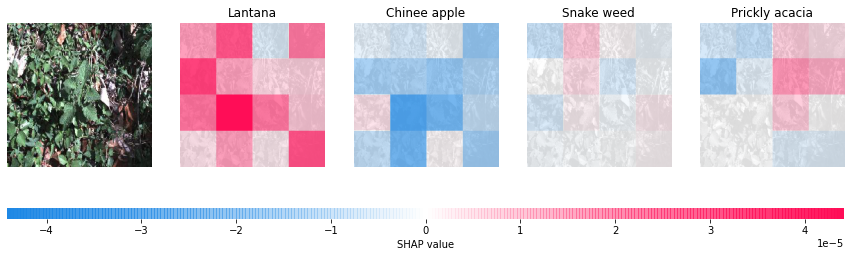

CPU times: user 8.46 s, sys: 119 ms, total: 8.58 s
Wall time: 8.7 s


In [31]:
%%time
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(images[0:1], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# output with shap values
shap.image_plot(shap_values)

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [01:23, 83.78s/it]               


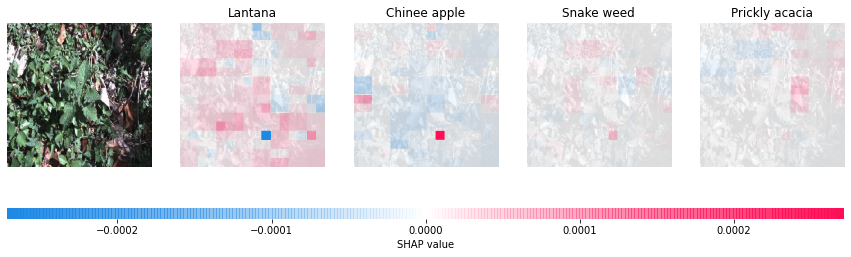

CPU times: user 1min 18s, sys: 530 ms, total: 1min 19s
Wall time: 1min 24s


In [32]:
%%time
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(images[0:1], max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# output with shap values
shap.image_plot(shap_values)

# fill all models with explanations

In [33]:
def createFolder (path):
  try:
    os.mkdir(path)
  except:
    pass
    


In [34]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        # x = inc_net.preprocess_input(x)
        x = x/255 #right preprocessing
        out.append(x)
    return np.vstack(out)


In [35]:
def load_Image_no_transform(path_img):
  img = load_img(path_img, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  img_batch = img_batch/255
  return img_batch


In [36]:
# selectable_models = ['2022-03-28__00-59-17_Chain_2_MobileNetV2_hillLR_full_dataset__very_low_lr']

In [37]:
def loadModel_interact(selected_model_folder):
  # make the model available for later
  global model
  global results_combined
  global model_dir_selected
  # reset
  model = None
  results_combined = None
  model_dir_selected = None
  
  model_dir_selected = selected_model_folder
  # load the model
  model, results_combined = loadModelAndResuls(selected_model_folder)
  print("loaded model: ", selected_model_folder )

interact(loadModel_interact, 
  selected_model_folder = widgets.Dropdown(
    options=selectable_models,
    value = '2022-03-28__00-59-17_Chain_2_MobileNetV2_hillLR_full_dataset__very_low_lr' #best model
  )
  
)

interactive(children=(Dropdown(description='selected_model_folder', index=7, options=('2022-03-27__22-21-46_Mo…

<function __main__.loadModel_interact>

In [38]:
#@title Save all model predictions and XAI images for models in selectable_models array

Run_XAI_Save = True #@param ["False", "True"] {type:"raw"}

In [43]:
if Run_XAI_Save:


  createFolder(os.path.join(models_folder,model_dir_selected,"XAI"))

  for filename in os.listdir(test_folder_lime_test):
    print(filename)

    filename_test =os.path.join("test",filename)
    filename_raw = filename.split(".jpg")[0]
    
    # try:
    #### Normal prediction
      #query the data
    results_combined_row = results_combined[results_combined['Filename']==filename_test]
    display(pd.DataFrame(results_combined_row))
    # show the figure

    # create a graph for the predictions
    #mark the actual class
    # colors = ['#636EFA',] * 9
    # if int(results_combined_row[['Actual_num']].iloc[0,0]) == 8:
    #   colors[2] = 'crimson'
    # elif int(results_combined_row[['Actual_num']].iloc[0,0]) > 1:
    #   colors[int(results_combined_row[['Actual_num']].iloc[0,0])+1] = 'crimson'
    # else:
    #   colors[int(results_combined_row[['Actual_num']].iloc[0,0])] = 'crimson'
      

    fig2 = go.Figure(
        [go.Bar(
        x=CLASSES, 
        y=np.array(results_combined_row.iloc[: , 3:-1 ])[0],
        # marker_color=colors
        )],
        
    layout_title_text="Predicted: {} <br>Actual: {} (red) <br>Test Image: {}".format(results_combined_row.iloc[0,1],
                                                                        results_combined_row.iloc[0,12],filename),
    )
    # fig2.show() #does not work
    fig2.write_html(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_prediction.html".format(filename_raw)))
    # fig2.write_image(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_prediction.html".format(filename_raw)))
    # except:
    #   pass

    try:
      #### Lime explanation
      images_lime = transform_img_fn([os.path.join(test_folder_lime_test,filename)])

      explainer = lime_image.LimeImageExplainer()

      # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
      explanation = explainer.explain_instance(images_lime[0].astype('double'), model, top_labels=5, hide_color=0, num_samples=1000)

      IMPORTANTCLASS = 0

      amount_of_pic = 20

      line = 0
      i_line = 0
      figure, axes = plt.subplots(nrows=(int(amount_of_pic/5))+1, ncols=4,figsize=(15, 15))
      for i in range(0,amount_of_pic):  
          temp, mask = explanation.get_image_and_mask(IMPORTANTCLASS, positive_only=False, num_features=i, hide_rest=False)#hide_rest=False)
      
          if i % 4 == 0 and i != 0:
              line = line+1
              i_line = 0
          
          axes[line,i_line].imshow(mark_boundaries(temp, mask))
          axes[line,i_line].set_title('Important Range 1 to {}'.format(i+1))
          i_line = i_line+1

      figure.tight_layout()
      plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_Lime_1000.jpg".format(filename_raw)))
      
    except:
      pass
    try:
      plt.close()
    except:
      print('could not close image')
      pass

    # try:

    #### Shap explanatino
    print("Shap 100")

    shap.initjs()

    images = load_Image_no_transform(os.path.join(test_folder_lime_test,filename))
    # define a masker that is used to mask out partitions of the input image.
    masker = shap.maskers.Image("inpaint_telea", images[0].shape)

    # create an explainer with model and image masker
    explainer = shap.Explainer(f_own, masker, output_names=CLASSES)

    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(images[0:1], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

    # output with shap values
    shap.image_plot(shap_values, show=True)#.savefig('scratch.png')#.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_100.jpg".format(filename_raw)))

    try:
      plt.close()
    except:
      print('could not close image')
      pass

    print("Shap 500")
    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(images[0:1], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

    # output with shap values
    shap.image_plot(shap_values)
    try:
      plt.close()
    except:
      pass

      # save
      # plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_500.jpg".format(filename_raw))) # does not work
    # except:
    #   pass


Output hidden; open in https://colab.research.google.com to view.

In [44]:
# if Run_XAI_Save:
#   for model_dir_selected in selectable_models:
#     print("\n",model_dir_selected)
#     # load the model
#     model, results_combined = loadModelAndResuls(model_dir_selected)

#     createFolder (os.path.join(models_folder,model_dir_selected,"XAI"))

#     for filename in os.listdir(test_folder_lime_test):
#       print(filename)

#       filename_test =os.path.join("test",filename)
#       filename_raw = filename.split(".jpg")[0]
      
#       # try:
#       #### Normal prediction
#         #query the data
#       results_combined_row = results_combined[results_combined['Filename']==filename_test]
#       display(pd.DataFrame(results_combined_row))
#       # show the figure

#       # create a graph for the predictions
#       #mark the actual class
#       # colors = ['#636EFA',] * 9
#       # if int(results_combined_row[['Actual_num']].iloc[0,0]) == 8:
#       #   colors[2] = 'crimson'
#       # elif int(results_combined_row[['Actual_num']].iloc[0,0]) > 1:
#       #   colors[int(results_combined_row[['Actual_num']].iloc[0,0])+1] = 'crimson'
#       # else:
#       #   colors[int(results_combined_row[['Actual_num']].iloc[0,0])] = 'crimson'
        

#       fig2 = go.Figure(
#           [go.Bar(
#           x=CLASSES, 
#           y=np.array(results_combined_row.iloc[: , 3:-1 ])[0],
#           # marker_color=colors
#           )],
          
#       layout_title_text="Predicted: {} <br>Actual: {} (red) <br>Test Image: {}".format(results_combined_row.iloc[0,1],
#                                                                           results_combined_row.iloc[0,12],filename),
#       )
#       # fig2.show() does not work
#       fig2.write_html(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_prediction.html".format(filename_raw)))
#       # fig2.write_image(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_prediction.html".format(filename_raw)))
#       # except:
#       #   pass

#       try:
#         #### Lime explanation
#         images_lime = transform_img_fn([os.path.join(test_folder_lime_test,filename)])

#         explainer = lime_image.LimeImageExplainer()

#         # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
#         explanation = explainer.explain_instance(images_lime[0].astype('double'), model, top_labels=5, hide_color=0, num_samples=1000)

#         IMPORTANTCLASS = 0

#         amount_of_pic = 20

#         line = 0
#         i_line = 0
#         figure, axes = plt.subplots(nrows=(int(amount_of_pic/5))+1, ncols=4,figsize=(15, 15))
#         for i in range(0,amount_of_pic):  
#             temp, mask = explanation.get_image_and_mask(IMPORTANTCLASS, positive_only=False, num_features=i, hide_rest=False)#hide_rest=False)
        
#             if i % 4 == 0 and i != 0:
#                 line = line+1
#                 i_line = 0
            
#             axes[line,i_line].imshow(mark_boundaries(temp, mask))
#             axes[line,i_line].set_title('Important Range 1 to {}'.format(i+1))
#             i_line = i_line+1

#         figure.tight_layout()
#         plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_Lime_1000.jpg".format(filename_raw))) 
#       except:
#         pass

#       # try:

#       #### Shap explanatino
#       print("Shap 100")

#       shap.initjs()

#       images = load_Image_no_transform(os.path.join(test_folder_lime_test,filename))
#       # define a masker that is used to mask out partitions of the input image.
#       masker = shap.maskers.Image("inpaint_telea", images[0].shape)

#       # create an explainer with model and image masker
#       explainer = shap.Explainer(f_own, masker, output_names=CLASSES)

#       # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
#       shap_values = explainer(images[0:1], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

#       # output with shap values
#       shap.image_plot(shap_values, show=True)#.savefig('scratch.png')#.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_100.jpg".format(filename_raw)))



#       print("Shap 500")
#       # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
#       shap_values = explainer(images[0:1], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

#       # output with shap values
#       shap.image_plot(shap_values)

#         # save
#         # plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_500.jpg".format(filename_raw))) # does not work
#       # except:
#       #   pass


In [45]:
# model_dir_selected = "2022-03-25__14-41-44_Test_run_for_chain"
# # make folder for image interpretattion

# # for filename in os.listdir(test_folder_lime_test):
# print(filename)
# filename ="20160928-141421-0.jpg"
# filename_test ="test/"+"20160928-141421-0.jpg"
# filename_raw = filename.split(".jpg")[0]

In [46]:
# os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_100.png".format(filename_raw))

In [47]:
# %matplotlib inline

# images = load_Image_no_transform(os.path.join(test_folder_lime_test,filename))
# # define a masker that is used to mask out partitions of the input image.
# masker = shap.maskers.Image("inpaint_telea", images[0].shape)

# # create an explainer with model and image masker
# explainer = shap.Explainer(f_own, masker, output_names=CLASSES)

# # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
# shap_values = explainer(images[0:1], max_evals=1, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# # output with shap values
# shap.image_plot(shap_values, show=True, )#.savefig('drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/models/2022-03-25__14-41-44_Test_run_for_chain/XAI/20160928-141421-0_SHAP_100.png')#.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_100.jpg".format(filename_raw)))

# # plt.savefig('drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/models/2022-03-25__14-41-44_Test_run_for_chain/XAI/20160928-141421-0_SHAP_100.png')

In [48]:

# model_dir_selected = "2022-03-25__14-41-44_Test_run_for_chain"
# # make folder for image interpretattion

# # for filename in os.listdir(test_folder_lime_test):
# print(filename)
# filename ="20160928-141421-0.jpg"
# filename_test ="test/"+"20160928-141421-0.jpg"
# filename_raw = filename.split(".jpg")[0]

# createFolder (os.path.join(models_folder,model_dir_selected,"XAI"))


# #### Normal prediction
#   #query the data
# results_combined_row = results_combined[results_combined['Filename']==filename_test]
# # print(filename)
# # show the figure

# # create a graph for the predictions
# #mark the actual class
# colors = ['#636EFA',] * 9
# if int(results_combined_row[['Actual_num']].iloc[0,0]) == 8:
#   colors[2] = 'crimson'
# elif int(results_combined_row[['Actual_num']].iloc[0,0]) > 1:
#   colors[int(results_combined_row[['Actual_num']].iloc[0,0])+1] = 'crimson'
# else:
#   colors[int(results_combined_row[['Actual_num']].iloc[0,0])] = 'crimson'
  

# fig2 = go.Figure(
#     [go.Bar(
#     x=CLASSES, 
#     y=np.array(results_combined_row.iloc[: , 3:-1 ])[0],
#     marker_color=colors
#     )],
    
# layout_title_text="Predicted: {} <br>Actual: {} (red) <br>Test Image: {}".format(results_combined_row.iloc[0,1],
#                                                                     results_combined_row.iloc[0,12],filename),

# )
# # fig2.show() does not work
# fig2.write_html(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_prediction.html".format(filename_raw)))
# # fig2.write_image(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_prediction.html".format(filename_raw)))


# # #### Lime explanation
# # images_lime = transform_img_fn([os.path.join(test_folder_lime_test,filename)])

# # explainer = lime_image.LimeImageExplainer()

# # # Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
# # explanation = explainer.explain_instance(images_lime[0].astype('double'), model, top_labels=5, hide_color=0, num_samples=1000)

# # IMPORTANTCLASS = 0

# # amount_of_pic = 20

# # line = 0
# # i_line = 0
# # figure, axes = plt.subplots(nrows=(int(amount_of_pic/5))+1, ncols=4,figsize=(15, 15))
# # for i in range(0,amount_of_pic):  
# #     temp, mask = explanation.get_image_and_mask(IMPORTANTCLASS, positive_only=False, num_features=i, hide_rest=False)#hide_rest=False)

# #     if i % 4 == 0 and i != 0:
# #         line = line+1
# #         i_line = 0
    
# #     axes[line,i_line].imshow(mark_boundaries(temp, mask))
# #     axes[line,i_line].set_title('Important Range 1 to {}'.format(i+1))
# #     i_line = i_line+1

# # figure.tight_layout()
# # plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_Lime_1000.jpg".format(filename_raw)))


# #### Shap explanatino
# print("Shap 100")

# shap.initjs()

# images = load_Image_no_transform(os.path.join(test_folder_lime_test,filename))
# # define a masker that is used to mask out partitions of the input image.
# masker = shap.maskers.Image("inpaint_telea", images[0].shape)

# # create an explainer with model and image masker
# explainer = shap.Explainer(f_own, masker, output_names=CLASSES)

# # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
# shap_values = explainer(images[0:1], max_evals=1, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# # output with shap values
# shap.image_plot(shap_values, show=True).savefig('scratch.png')#.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_100.jpg".format(filename_raw)))



# # print("Shap 500")
# # # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
# # shap_values = explainer(images[0:1], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# # # output with shap values
# # shap.image_plot(shap_values)

# # # save
# # plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_500.jpg".format(filename_raw)))



In [49]:

# ### f.show()
# # save
# plt.savefig(os.path.join(models_folder,model_dir_selected,"XAI" ,"{}_SHAP_100.jpg".format(filename_raw)))

# shap.force_plot(explainer.expected_value, shap_values[0,:],X.iloc[0,:],show=False,matplotlib=True).savefig('scratch.png')
# ### import matplotlib.pyplot as pl; f = pl.gcf()